# Vocab size 

how it affects word, and BPE models


In [1]:
import collections as coll
from pathlib import Path
import numpy as np

from tqdm import tqdm_notebook as tqdm, trange
import nlcodec
from nlcodec.qestim import QualityEstimator
import matplotlib.pyplot as plt
import logging as log
import seaborn as sns
#plt.rcParams.update(params)

log.basicConfig(level=log.INFO)

In [2]:
!ls ../work/wmt/data/*/europarl*.tok

ls: ../work/wmt/data/*/europarl*.tok: No such file or directory


In [4]:
!ls ../work/wmt/data/de-en/europarl-v9.de-en.en.tok

../work/wmt/data/de-en/europarl-v9.de-en.en.tok


In [3]:

def word_freqs(path):
    with path.open() as lines:
        log.info(f"Computing word frequencies {path}")        
        stats = coll.Counter(tok for line in lines for tok in line.strip().split())
        return stats


def EMD_match(stats, moving_cost=1, validate=True):
    n_types = len(stats)
    before = distr = stats / np.sum(stats)
    after = uniform = 1 / n_types 
    if validate:
        QualityEstimator.validate_distribution(before)
    assert moving_cost > 0
    diffs = (after - before) * moving_cost
    excess = np.sum((diffs > 0) * diffs) # positives
    little = np.sum((diffs < 0) * diffs) # negatives
    assert abs(abs(little) - excess) < 1e-5 # equal
    return excess
    
def find_js_div(stats):
    n_types = len(stats)
    uniform = np.full(shape=(n_types), fill_value=(1 / n_types), dtype=np.float)
    distr = stats / np.sum(stats)
    return QualityEstimator.js_div(base=uniform, distr=distr)


def get_type_stats(path, freq_func=word_freqs, imb_sample=10):
    
    tf_map = freq_func(path)
    tfs = tf_map.items()
    tfs = sorted(tfs, reverse=True, key=lambda x: x[1])
    types = [t for t, f in tfs]
    freqs = np.array([f for t, f in tfs])

    log.info("Computing OOVs")
    oovs = np.zeros(len(freqs))
    for i, f in enumerate(freqs):
        if i == 0:
            oovs[i] = np.sum(freqs) - f
        else:
            oovs[i] = oovs[i-1] - f
    
    log.info("Computing type imbalance")
    imb_x = np.arange(0, len(freqs), imb_sample)  # sampling at every 10 for speed reasons
    imb_y = np.zeros(len(imb_x))
    for i, t in tqdm(enumerate(imb_x), total=len(imb_x)):
        vocab = np.concatenate((np.array([oovs[t]]), freqs[:t+1]), axis=0)
        #imb_y[i] = find_js_div(vocab)
        imb_y[i] = EMD_match(vocab)

    imbalance = list(zip(imb_x, imb_y))
    log.info("All done")
    return freqs, oovs, imbalance


In [61]:
# debug
a = np.array([1, 10])

print(EMD_match(stats=a))
freqs = [20, 10, 5, 1]
oovs = np.zeros(len(freqs))
for i, f in enumerate(freqs):
    if i == 0:
        oovs[i] = np.sum(freqs) - f
    else:
        oovs[i] = oovs[i-1] - f
print(freqs, oovs)

0.40909090909090906
[20, 10, 5, 1] [16.  6.  1.  0.]


In [66]:
deen_en = Path('../work/wmt/data/de-en/europarl-v9.de-en.en.tok')
freqs, oovs, imbalance = get_type_stats(deen_en)

INFO:root:Computing word frequencies ../work/wmt/data/de-en/europarl-v9.de-en.en.tok
INFO:root:Computing OOVs
INFO:root:Computing type imbalance


INFO:root:All done


INFO:root:Saving to word-deen-en.pdf


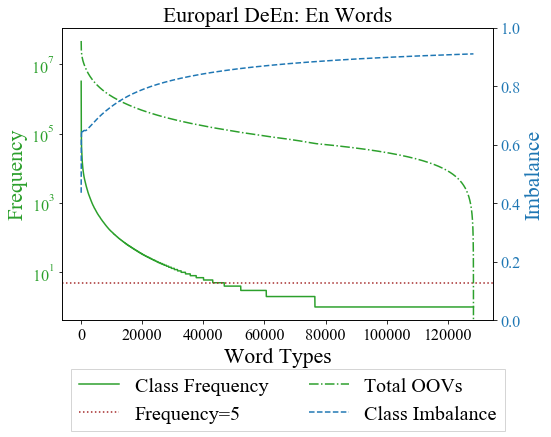

In [76]:
def plot_oov_imbalance(freqs, oovs, imbalance, title=None, freq_bar=5, x_label='Word Types', save=None):
    assert len(oovs) == len(freqs)
    x = np.arange(len(freqs))

    fig, ax1 = plt.subplots(figsize=(8, 6))
    #plt.legend('best')
    if title:
        plt.title(title)
    color = 'tab:green'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel('Frequency', color=color)
    ax1.set_yscale('log')
    l1 = ax1.plot(x, freqs, color=color, linestyle='-', label='Class Frequency')[0]
    l2 = ax1.axhline(y=freq_bar, color='brown', linestyle=':', label=f'Frequency={freq_bar}')

    l3 = ax1.plot(x, oovs, color=color, linestyle='-.', label='Total OOVs')[0]
    #ax1.axvline(x=32000, color='r', linestyle='-', label='Vocab Size=32k')
    #ax1.axvline(x=64000, color='r', linestyle='-', label='Vocab Size=64k')    
    ax1.tick_params(axis='y', labelcolor=color)
    #ax1.legend(loc="best")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    imb_x = [x for x, y in imbalance]
    imb_y = [y for x, y in imbalance]
    color = 'tab:blue'
    ax2.set_ylabel('Imbalance', color=color)  # we already handled the x-label with ax1
    l4 = ax2.plot(imb_x, imb_y, color=color, linestyle='--', label='Class Imbalance')[0]
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0, max(1, np.max(imb_y))])
    #ax2.legend(loc="upper center")

    lines = [l1, l2, l3, l4]
    labels = [l.get_label() for l in lines]
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.15, box.width, box.height * 0.9])

    plt.figlegend(lines, labels, 'lower center', bbox_to_anchor=(0.5, -0.01),
                  fancybox=False, shadow=False, ncol=2)
    
    if save:
        log.info(f'Saving to {save}')
        plt.savefig(save, pad_inches=0.1)
    plt.show()

plot_oov_imbalance(freqs, oovs, imbalance, title="Europarl DeEn: En Words", save='word-deen-en.pdf')

INFO:root:Computing word frequencies ../work/wmt/data/de-en/europarl-v9.de-en.de.tok
INFO:root:Computing OOVs
INFO:root:Computing type imbalance


INFO:root:All done


INFO:root:Saving to word-deen-de.pdf


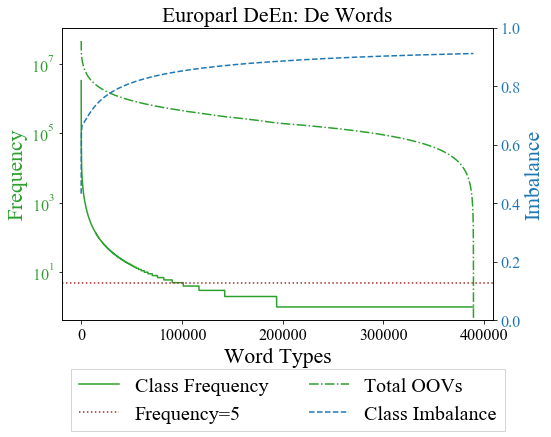

In [77]:
deen_de = Path('../work/wmt/data/de-en/europarl-v9.de-en.de.tok')
plot_oov_imbalance(*get_type_stats(deen_de, imb_sample=100), title="Europarl DeEn: De Words", save='word-deen-de.pdf')

INFO:root:Computing word frequencies ../work/wmt/data/fr-en/europarl-v7.fr-en.en.tok
INFO:root:Computing OOVs
INFO:root:Computing type imbalance


INFO:root:All done
INFO:root:Saving to word-fren-en.pdf


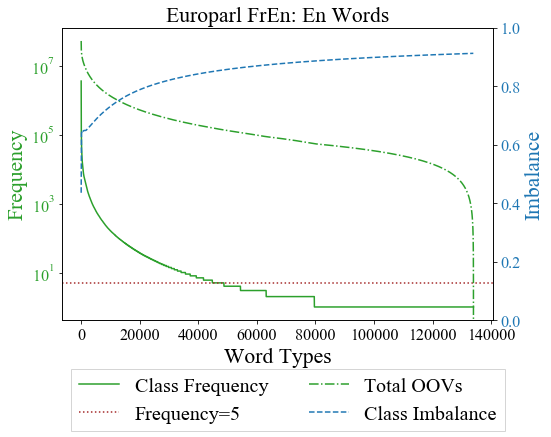

In [79]:
fren_en = Path('../work/wmt/data/fr-en/europarl-v7.fr-en.en.tok')
plot_oov_imbalance(*get_type_stats(fren_en, imb_sample=100), title="Europarl FrEn: En Words", save='word-fren-en.pdf')

INFO:root:Computing word frequencies ../work/wmt/data/fr-en/europarl-v7.fr-en.fr.tok
INFO:root:Computing OOVs
INFO:root:Computing type imbalance


INFO:root:All done
INFO:root:Saving to word-fren-fr.pdf


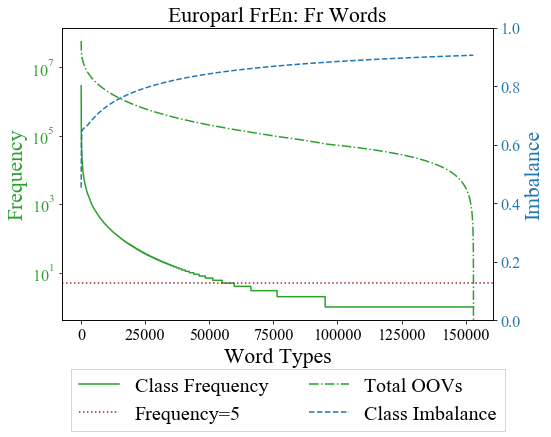

In [80]:
fren_fr = Path('../work/wmt/data/fr-en/europarl-v7.fr-en.fr.tok')
plot_oov_imbalance(*get_type_stats(fren_fr, imb_sample=100), title="Europarl FrEn: Fr Words", save='word-fren-fr.pdf')

# Character Model

In [2]:
def get_char_freqs(path):
    log.info(f'reading char stats {path}')
    with path.open() as lines:
        stats = coll.Counter(c for line in lines for c in line)
    return stats

INFO:root:reading char stats ../work/wmt/data/de-en/europarl-v9.de-en.de.tok
INFO:root:Computing OOVs
INFO:root:Computing type imbalance


INFO:root:All done
INFO:root:Saving to char-deen-de.pdf


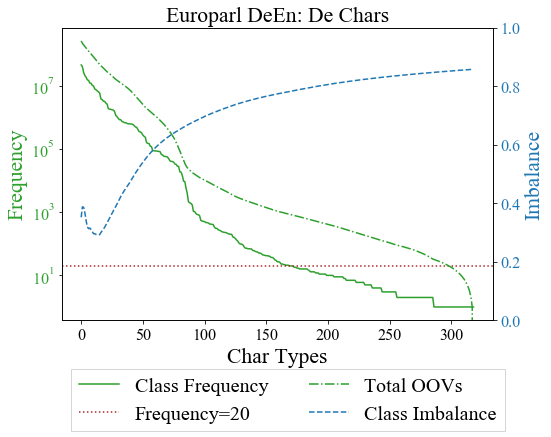

INFO:root:reading char stats ../work/wmt/data/de-en/europarl-v9.de-en.en.tok
INFO:root:Computing OOVs
INFO:root:Computing type imbalance


INFO:root:All done
INFO:root:Saving to char-deen-en.pdf


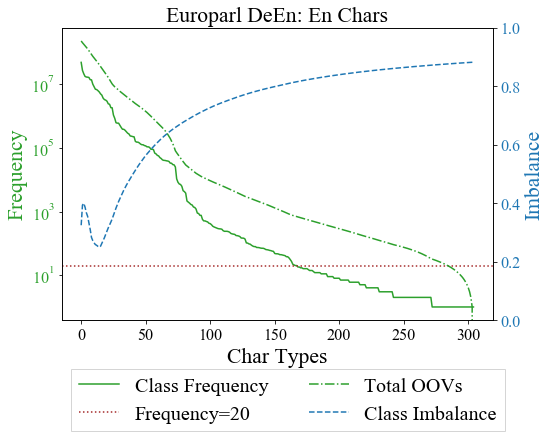

INFO:root:reading char stats ../work/wmt/data/fr-en/europarl-v7.fr-en.en.tok
INFO:root:Computing OOVs
INFO:root:Computing type imbalance


INFO:root:All done
INFO:root:Saving to char-fren-en.pdf


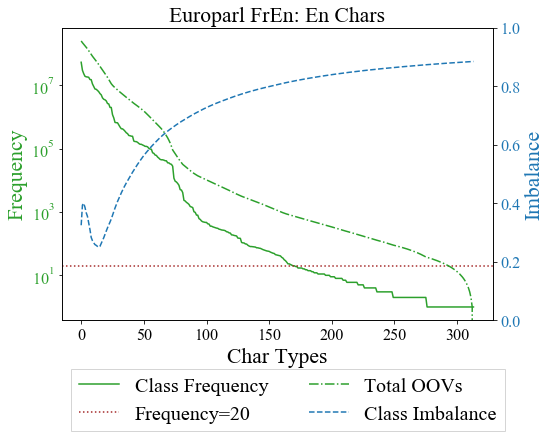

INFO:root:reading char stats ../work/wmt/data/fr-en/europarl-v7.fr-en.fr.tok
INFO:root:Computing OOVs
INFO:root:Computing type imbalance


INFO:root:All done
INFO:root:Saving to char-fren-fr.pdf


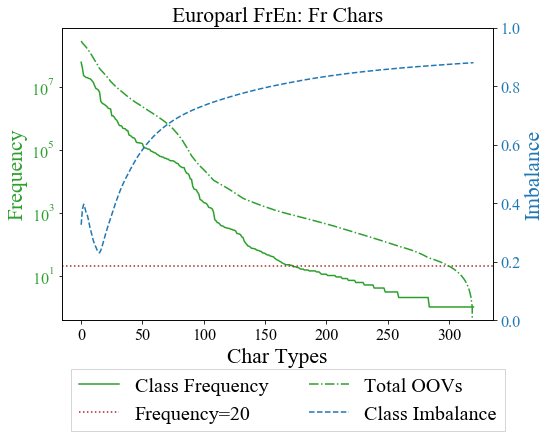

In [82]:
datasets = [
    ('../work/wmt/data/de-en/europarl-v9.de-en.de.tok', 'Europarl DeEn: De Chars', "char-deen-de.pdf"),
    ('../work/wmt/data/de-en/europarl-v9.de-en.en.tok', 'Europarl DeEn: En Chars', "char-deen-en.pdf"),
    ('../work/wmt/data/fr-en/europarl-v7.fr-en.en.tok', 'Europarl FrEn: En Chars', "char-fren-en.pdf"),
    ('../work/wmt/data/fr-en/europarl-v7.fr-en.fr.tok', 'Europarl FrEn: Fr Chars', "char-fren-fr.pdf"),
    #('../work/wmt/data/lt-en/europarl-v9.lt-en.lt.tok', 'LtEn: Lt'),    
    #('../work/wmt/data/lt-en/europarl-v9.lt-en.en.tok', 'LtEn: En')
]
for p, title, save in datasets:
    p = Path(p)
    stats = get_type_stats(p, imb_sample=1, freq_func=get_char_freqs)
    plot_oov_imbalance(*stats, title=f'{title}', freq_bar=20, save=save, x_label='Char Types')



# Byte Pair Encoding

In [213]:
!head -20 ../bpe32k.de.vocab

#{"total": 32000, "version": 0.1, "levels": {"-1": 6, "0": 170, "1": 31824}, "max_level": 1, "created": "2019-11-07 11:08:31.063021"}
0	<pad>	-1	-1	
1	<unk>	-1	-1	
2	<s>	-1	-1	
3	</s>	-1	-1	
4	<cls>	-1	-1	
5	▁	-1	-1	
6	e	0	41043349	
7	n	0	26574324	
8	i	0	21462728	
9	r	0	18891760	
10	s	0	15655981	
11	t	0	15054327	
12	d	0	12362979	
13	a	0	12200862	
14	h	0	10528555	
15	u	0	9940093	
16	l	0	8059554	
17	g	0	7590071	
18	c	0	7068592	


In [211]:
from nlcodec import load_scheme

In [251]:
!ls ..

LICENSE.txt         bpe32k.de.vocab     nlcodec             scripts
README.md           deen.en.bpe8k.model nlcodec.egg-info    setup.py
bpe128k.de.vocab    experimental        notes               work


In [383]:
bpemodel = load_scheme()

INFO:root:read 64000 types from ../deen.en.bpe64k.model
INFO:root:Vocab size=64000; trie root has nodes=191293 but data_nodes=64000


In [10]:
cat ../work/wmt/data/de-en/europarl-v9.de-en.en.tok | shuf | head -100000 > ../work/wmt/data/de-en/europarl-v9.de-en.en.tok.100k

shuf: write error: Broken pipe
shuf: write error


In [3]:
from nlcodec.eval.bpe_len import BPECodecXt, BpeTracker

ModuleNotFoundError: No module named 'nlcodec.eval'

In [5]:
dataset = Path('../work/wmt/data/de-en/europarl-v9.de-en.en.tok.100k')
lines = [l.strip() for l in dataset.open()]
log.info(f'num lines= {len(lines)}')
bpe = BPECodecXt('../deen.en.nmt.bpe64k.model')
tracker = BpeTracker(bpe, data=lines)
#res = tracker.track_merges()

INFO:root:num lines= 100000
INFO:root:read 64000 types from ../deen.en.nmt.bpe64k.model
INFO:root:Vocab size=172; trie root has nodes=186 but data_nodes=172
INFO:root:initial table has 172; buffer has 63828
INFO:root:Encoding and creating index
0it [00:00, ?it/s]INFO:root:Going to use 3 parallel processes 
100000it [01:03, 1577.88it/s, MaxRSS=3551MB]
INFO:root:Found 100000 sentences


In [6]:
res = tracker.track_merges()
res[:10]

INFO:root:64000: imbalance=0.868838 mean_seq_len=27.6247.


[(172, 0.82350780840089, 151.2621),
 (173, 0.8172191713479177, 146.06545),
 (174, 0.8114063110921718, 142.72321),
 (175, 0.805638516369614, 139.49177),
 (176, 0.8000680529658888, 136.87801),
 (177, 0.794554851820493, 134.36998),
 (178, 0.7892415287403423, 132.41007),
 (179, 0.7840244049006113, 130.63983),
 (180, 0.7789138493997787, 129.07989),
 (181, 0.7738607609460777, 127.5763)]

INFO:root:Saving to bpe64k-deen-en.pdf


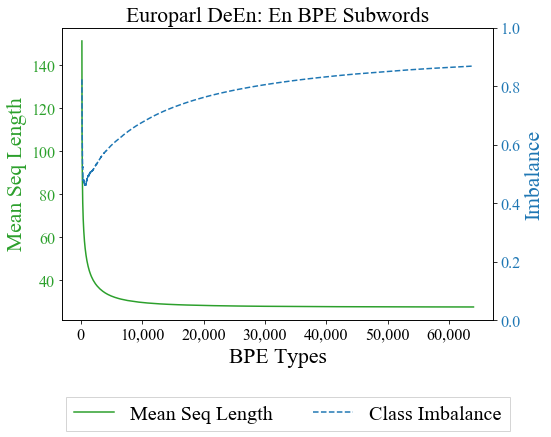

In [13]:
def plot_BPE_len_imbalance(data, title=None, freq_bar=5, x_label='BPE Types', save=None):

    merges = [m for m, im, l in data]
    imbalance = [im for m, im, l in data]
    seq_lens = [l for m, im, l in data]

    fig, ax1 = plt.subplots(figsize=(8, 6))
    #plt.legend('best')
    if title:
        plt.title(title)
    color = 'tab:green'
    
    ax1.set_xlabel(x_label)
    ax1.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x):,}"))
    ax1.set_ylabel('Mean Seq Length', color=color)
    #ax1.set_yscale('log')
    
    l1 = ax1.plot(merges, seq_lens, color=color, linestyle='-', label='Mean Seq Length')[0]
    #vocab_bar = 8000
    #l3 = ax1.axvline(x=vocab_bar, color='brown', linestyle=':', label=f'BPE Vocab={vocab_bar}')

    ax1.tick_params(axis='y', labelcolor=color)
    #ax1.legend(loc="best")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Imbalance', color=color)  # we already handled the x-label with ax1
    l2 = ax2.plot(merges, imbalance, color=color, linestyle='--', label='Class Imbalance')[0]
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0, max(1, np.max(imbalance))])
    #ax2.legend(loc="upper center")

    lines = [l1, l2]
    labels = [l.get_label() for l in lines]
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height * 0.15, box.width, box.height * 0.9])
    
    plt.figlegend(lines, labels, 'lower center', bbox_to_anchor=(0.5, -0.01),
                  fancybox=False, shadow=False, ncol=3)

    if save:
        log.info(f'Saving to {save}')
        plt.savefig(save, pad_inches=0.1)
    plt.show()

plot_BPE_len_imbalance(res, title='Europarl DeEn: En BPE Subwords', save='bpe64k-deen-en.pdf')

In [381]:
freqs = [t.freq for t in init_vocab]
vocab = copy.copy(init_vocab)

print('Initial', sum(freqs))

imbalance = []
for i, m in tqdm(enumerate(merges, start=len(init_vocab)), total=len(merges)):
    assert m.idx == len(freqs) == len(vocab), f'{m.idx} {len(freqs)} {len(vocab)}'
    #print('>>', i, m)
    vocab.append(m)
    freqs.append(m.freq)
    
    for k in m.kids or []: # move frequency out of pieces to composite
        assert k.name == vocab[k.idx].name
        assert freqs[k.idx] >= m.freq, f'{freqs[k.idx]} >= {m.freq}; {m} kid={k.name}'
        freqs[k.idx] -= m.freq

    stats = freqs[5:] # exclude the first few reserved words such as pad, bos, eos, etc. UNK is excluded as well, that should be okay
    imbalance.append((i, EMD_match(stats)))

print("Done", i)

Initial 277874557


Done 63999


INFO:root:Saving bpe64k-deen-en.pdf


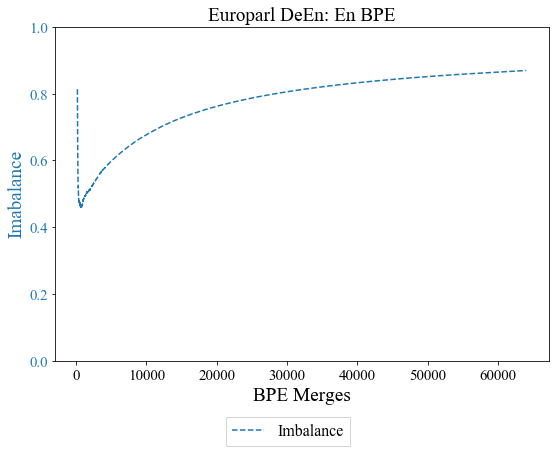

In [382]:
def plot_BPE_imbalance(imbalance, title=None, freq_bar=5, x_label='BPE Merges', save=None):

    x = np.arange(len(freqs))

    fig, ax2 = plt.subplots(figsize=(8, 6))
    #plt.legend('best')
    if title:
        plt.title(title)
    color = 'tab:green'
    ax2.set_xlabel(x_label)

    imb_x = [x for x, y in imbalance]
    imb_y = [y for x, y in imbalance]
    color = 'tab:blue'
    ax2.set_ylabel('Imabalance', color=color)  # we already handled the x-label with ax1
    l4 = ax2.plot(imb_x, imb_y, color=color, linestyle='--', label='Imbalance')[0]
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0, max(1, np.max(imb_y))])
    #ax2.legend(loc="upper center")
    
     
    lines = [l4]
    labels = [l.get_label() for l in lines]
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height])
    
    plt.figlegend(lines, labels, 'lower center', bbox_to_anchor=(0.5, -0.0),
                  fancybox=False, shadow=False, ncol=2)

    if save:
        log.info(f"Saving {save}")
        plt.savefig(save)
    plt.show()

plot_BPE_imbalance(imbalance, title="Europarl DeEn: En BPE", save='bpe64k-deen-en.pdf')

---- 
# Buffer / Scratch pad


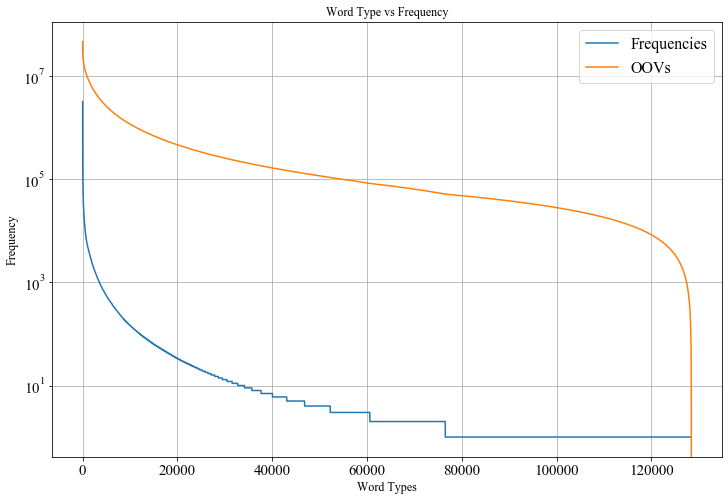

In [31]:
def plot_graph(*stats, names=None):
    for i in range(len(stats)):
        assert len(stats[i]) == len(stats[0]), f'arg {i} has {len(stats[i])}, but 0th arg has {len(stats[0])}'
    assert names and len(names) == len(stats)
    plt.figure(figsize=(12, 8))
    
    t = np.arange(len(stats[0]))
    #plt.plot(t, *stats)
    for i in range(len(stats)):
        plt.plot(t, stats[i], label=names[i])
    
    plt.legend(loc="upper right")
    plt.yscale('log')
    plt.ylabel('Frequency')
    plt.xlabel('Word Types')
    plt.title('Word Type vs Frequency')
    plt.grid(True)

    plt.show()

plot_graph(freqs, oovs, names=["Frequencies", "OOVs"])